In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import pydot
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'joblib'

# Functions to build tree

In [2]:
def causal_train_test_split(data, predictors, response, treatment, test_size = 0.25, estimation_size = 0.33):
    
    global PROP
    PROP = 1 - estimation_size
    
    train_set, test_set = train_test_split(data, test_size=test_size)
    training_sample, estimation_sample = train_test_split(train_set, test_size=estimation_size)
    training_sample.insert(loc = 0, column = 'TRAIN_ESTIMATION_IND', value = np.ones(len(training_sample)))
    estimation_sample.insert(loc = 0, column = 'TRAIN_ESTIMATION_IND', value = np.zeros(len(estimation_sample)))
    new_train_set = pd.concat([training_sample, estimation_sample])
    new_train_set = new_train_set[['TRAIN_ESTIMATION_IND'] + predictors + treatment + response]
    test_set = test_set[predictors + treatment + response]
    return new_train_set, test_set

In [3]:
def data_split(index, value, dataset):
    """ 
    A function seperate a dataset into two numpy matrices 
    given the index of an attribute and a split value for that attribute
    
    Input:
    ------
        index(int): the index of the columns of the dataset
        value(float): the value to be compared with
        dataset(numpy array): the dataset to split
    
    Output:
    ------:
        left(numpy array): the dataset that is split(left half)
        right(numpy array): the dataset that is split(right half)
    
    """
    dim = dataset.shape[1]
    left, right = np.empty(shape=[0, dim]), np.empty(shape=[0, dim])
    for row in dataset:
        if row[index] < value:
            left = np.append(left, [row], axis = 0)
        else:
            right = np.append(right, [row], axis = 0)
    return left, right

In [4]:
def get_emse(train, est, row, index):
    
    # check the cardinality of the training and estimation samples, if size < *threshold*
    # then can not do the calculation
    train_size = len(train)
    est_size = len(est)
    
    # split both training sample and estimation sample using the same rule
    left_train, right_train = data_split(index, row[index], train)
    left_est, right_est = data_split(index, row[index], est)
    

    ### Calculate the estimated treatment effect
            
    # get the cardinality of training sample for both leaves
    left_train_size = len(left_train)
    right_train_size = len(right_train)
    
    # calculate the treatment effect for both leaves, 
    left_est_response_trt = get_response(left_est, 'treatment') 
    left_est_response_ctl = get_response(left_est, 'control') 
    right_est_response_trt = get_response(right_est, 'treatment') 
    right_est_response_ctl = get_response(right_est, 'control') 
    #check cardinality of each leaf, make sure each leaf has at least *threshold* (chould be changed by user)
    # treatment and n control to do the calculation
    
    left_trt_effect = left_est_response_trt.mean() - left_est_response_ctl.mean()
    right_trt_effect = right_est_response_trt.mean() - right_est_response_ctl.mean()
    
    # then calculated the estimated squared treatment effect
    e_trt_effect = (left_train_size * (left_trt_effect ** 2) + right_train_size * (right_trt_effect ** 2))/(train_size)
    
            
    ### Calculate the estimated variance
    left_var = np.var(left_est_response_trt) / PROP + np.var(left_est_response_ctl) / (1 - PROP)
    right_var = np.var(right_est_response_trt) / PROP + np.var(right_est_response_ctl) / (1 - PROP)
    e_var = (1 / train_size + 1 / est_size) * (left_var + right_var)
    
    
    ### Calculate EMSE
    emse = e_trt_effect - e_var    
    
    return emse
    
def get_split_emse(dataset, n_predictors):
 
    train = dataset[dataset[:,0] == 1]
    est = dataset[dataset[:,0] == 0]
    
    #get the random n predictors for each node
    num_total_predictors = train.shape[1] - 3
    predictor_subset_ind = random.sample(range(1, 1 + num_total_predictors), n_predictors)
    

    # initialize values to return
    b_index, b_value, b_score, b_groups = float('inf'), float('inf'), float('-inf'), None
    
    for index in predictor_subset_ind:
        for row in train:
            groups = data_split(index, row[index], dataset)
            emse = get_emse(train, est, row, index)
            # if mse score gets improved (reduced actually), update the information
            if emse > b_score:# and emse is not np.nan:
                b_index, b_value, b_score, b_groups = index, row[index], emse, groups   
                
    ret_dict =  {'index':b_index, 'value':b_value, 'groups':b_groups}
    return ret_dict

In [5]:
def get_response(dataset, trt):
    if trt == 'treatment':
        return dataset[dataset[:,-2] == 1][:,-1]
    elif trt == 'control':
        return dataset[dataset[:,-2] == 0][:,-1]

In [6]:
# get the split based on criterion
def get_split(dataset, criterion, n_predictors):
    """ 
    A function to split the data based on splitting criterion specified by user
    
    Input:
    ------
        dataset(np array): a dataset in the form of a numpy matrix
        criterion(str): a str to indicate the criterion specified by user
    
    Output:
    ------:
        the same output as functions get_split_xxx
    
    """    
    if criterion == 'mse':
        return get_split_mse(dataset)
    if criterion == 'causal':
        return get_split_emse(dataset, n_predictors)    
    elif criterion == 'gini':
        return get_split_gini(dataset)

In [7]:
# Create a terminal node value
def to_terminal_gini(group):
    response = group[:,-1]
    return stats.mode(response)[0][0] # this could be optimized

def to_terminal_mse(group):
    response = group[:,-1]
    return np.mean(response)

def to_terminal_emse(group):
    est_trt = get_response(group, 'treatment')
    est_ctl = get_response(group, 'control')
    
    causal_effect = np.mean(est_trt) - np.mean(est_ctl)
    proportion_of_data = (len(est_trt) + len(est_ctl)) / TOTAL_DATA_COUNT
    
    return causal_effect, round(proportion_of_data * 100, 1)
    
    
def to_terminal(group, criterion):
    if criterion == 'gini':
        return to_terminal_gini(group)
    elif criterion == 'mse':
        return to_terminal_mse(group)
    elif criterion == 'causal':
        return to_terminal_emse(group)

In [8]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth, criterion, n_predictors):
    
    left, right = node['groups']
    
    left_train = left[left[:,0] == 1]
    left_est = left[left[:,0] == 0]
    right_train = right[right[:,0] == 1]
    right_est = right[right[:,0] == 0]    
    
    left_train_response_trt = get_response(left_train, 'treatment')
    left_train_response_ctl = get_response(left_train, 'control')
    right_train_response_trt = get_response(right_train, 'treatment')
    right_train_response_ctl = get_response(right_train, 'control')  
    
    left_est_response_trt = get_response(left_est, 'treatment')
    left_est_response_ctl = get_response(left_est, 'control')
    right_est_response_trt = get_response(right_est, 'treatment')
    right_est_response_ctl = get_response(right_est, 'control')
    
    del(node['groups'])
    
    if len(left) == 0 or len(right) == 0:
        node['left'] = node['right'] = to_terminal(np.append(left, right, axis = 0), criterion)
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left, criterion), to_terminal(right, criterion)
        return
    
    # process left child
    if (len(left) <= min_size or len(left_est_response_trt) <= min_size or len(left_est_response_ctl) <= min_size or
        len(right_est_response_trt) <= min_size or len(right_est_response_ctl) <= min_size or 
        len(left_train_response_trt) <= min_size or len(left_train_response_ctl) <= min_size or 
        len(right_train_response_trt) <= min_size or len(right_train_response_ctl) <= min_size):
        node['left'] = to_terminal(left, criterion)
    else:
        node['left'] = get_split(left, criterion, n_predictors)
        if node['left']['groups'] is None:
            node['left'] = to_terminal(left, criterion)
        else:
            split(node['left'], max_depth, min_size, depth+1, criterion, n_predictors)
        
    # process right child
    if (len(right) <= min_size or len(left_est_response_trt) <= min_size or len(left_est_response_ctl) <= min_size or
        len(right_est_response_trt) <= min_size or len(right_est_response_ctl) <= min_size or 
        len(left_train_response_trt) <= min_size or len(left_train_response_ctl) <= min_size or 
        len(right_train_response_trt) <= min_size or len(right_train_response_ctl) <= min_size):
        node['right'] = to_terminal(right, criterion)
    else:
        node['right'] = get_split(right, criterion, n_predictors)
        if node['right']['groups'] is None:
            node['right'] = to_terminal(right, criterion)
        else:
            split(node['right'], max_depth, min_size, depth+1, criterion, n_predictors)

In [9]:
# Build a decision tree
def causalTree(train, max_depth, min_size, criterion, n_predictors):
    
    global TOTAL_DATA_COUNT, COLUMN_NAMES
    TOTAL_DATA_COUNT = len(train)
    COLUMN_NAMES = train.columns[1:-2]
    
    train = np.array(train)
    
    if criterion == 'mse' or criterion == 'gini':
        root = get_split(train, criterion)
        #print(root)
        split(root, max_depth, min_size, 1, criterion)
        
    elif criterion == 'causal':
        root = get_split(train, criterion, n_predictors)
        split(root, max_depth, min_size, 1, criterion, n_predictors)
    return root

# Functions to use causal tree

In [10]:
#print out the tree structure
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth * ' ', (COLUMN_NAMES[node['index'] - 1]), node['value'])))
        print_tree(node['left'], depth + 1)
        print_tree(node['right'], depth + 1)
    else:
        print('%s[%s, %s%%]' % ((depth * ' ', node[0], node[1])))

        
#causal effect prediction
def causalPredict_helper(node,row):
    if row[node['index'] - 1] < node['value']:
        if isinstance(node['left'], dict):
            return causalPredict_helper(node['left'], row)
        else:
            return node['left'][0]
    else:
        if isinstance(node['right'], dict):
            return causalPredict_helper(node['right'], row)
        else:
            return node['right'][0]    
            
def causalPredict(test, tree):
    #get the information of the trainning set and initialize an empty return dataframe
    column_names = list(test.columns) + ['pred_causal_effect']
    test_matrix = np.array(test)
    ret_matrix = np.empty([0, test_matrix.shape[1] + 1])
    
    #predict for each row
    for row in test_matrix:
        row = np.insert(row, len(row), causalPredict_helper(tree, row))
        ret_matrix = np.append(ret_matrix, [row], axis = 0) 
    
    #return a new dataframe with the predicted value at the end of each row
    ret_df = pd.DataFrame(ret_matrix, columns = column_names)

    return ret_df

# random forest

In [11]:
def rf_sample(train_set, sample_ratio, n_predictors):
    ###a helper function to create a new random forest training set
    
#     #get subset of predictors based on given num of predictors
#     num_total_predictors = len(train_set.columns) - 3
#     predictor_subset_ind = random.sample(range(1, 1 + num_total_predictors), n_predictors)
#     rf_columns = ['TRAIN_ESTIMATION_IND'] + list(train_set.columns[predictor_subset_ind]) + ['trt', 'y']
#     train_subset = train_set[rf_columns]
    
    #get a subset of rows based on given sample ratio with replacement/bootsrap
    n_row = int(sample_ratio * len(train_set))
    new_train_subset = train_set.sample(n = n_row, replace = True, axis = 0)
    
    return new_train_subset

In [12]:
# function to build a random forest predictor
def causalRandomForest(train_set, max_depth, min_size, criterion, sample_ratio, n_predictors, n_trees):
    tree_lst = []
    for i in range(n_trees):
        #get rf sub training data
        rf_train_set = rf_sample(train_set, sample_ratio, n_predictors)
        #build the tree
        tree = causalTree(rf_train_set, max_depth, min_size, criterion, n_predictors)    
        tree_lst.append(tree)
        
    return tree_lst

In [13]:
def predictTestSet(rf, test_set):
       
    n_trees = len(rf)
    n_test_set = len(test_set)
    pred_value_list = np.empty([1,n_test_set])
    p_value_list = np.empty([1,n_test_set])  
    
    for tree in rf:
        # get the prediction for each tree
        pred_df = causalPredict(test_set, tree)
        pred_values = np.array(pred_df['pred_causal_effect'])
        # aggregate the prediction
        pred_value_list = pred_value_list + pred_values
        
        # get the number of negative causal effect in the prediction
        pred_values[pred_values >= 0] = 0 # set positive causal effect to 0
        pred_values[pred_values < 0] = 1 # set negative causal effect to 1
        p_value_list = p_value_list + pred_values
        
    #calculate the prediction of bagged trees for each data point
    pred_value_rf = np.round_(pred_value_list / n_trees, decimals = 3)
    #calculate the p value of bagged trees for each data point
    p_value_rf = np.round_(p_value_list / n_trees, decimals = 3)
    
    #append the prediction and p_value to the dataset
    ret_data = test_set.copy()
    ret_data['rf_pred_causal_effect'] = pred_value_rf[0]
    # calculate the p value against the hypothesis that the causal effect is not 0
    ret_data['rf_p_value'] = p_value_rf[0]
    ret_data['rf_p_value'] = ret_data['rf_p_value'].apply(lambda row: 2*row if row < 0.5 else 2*(1-row))
    
    return ret_data        

In [14]:
def predictDataPoint(rf, data):
    test_set = pd.DataFrame([data], columns = data.keys())
    predict_list = []
    for tree in rf:
        pred_df = causalPredict(test_set, tree)
        pred_value = pred_df.iloc[0,-1]
        predict_list.append(pred_value)
    # calculate the predicted value    
    rf_pred_value = round(np.mean(predict_list),3)
    # calculate p-value
    positive_ratio = sum(x >0 for x in predict_list)/len(predict_list)
    if positive_ratio <= 0.5:
        p_value = 2*positive_ratio
    else:
        p_value = 2*(1-positive_ratio)
    print("Predicted causal effect: " + str(rf_pred_value) + "\n")
    print("P-value: " + str(p_value))

# test - simulation study

In [15]:
# random forest test
rf_df = pd.read_csv('fake_data_large.csv')

#get the column names of predictors
p_str = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
#get the column name of response
r_str = ['design1_y']
#get the column name of treatment
t_str = ['treatment']

#set a random seed for replication 
np.random.seed(42)

#split the data
rf_train_set, rf_test_set = causal_train_test_split(rf_df, predictors = p_str, response = r_str, treatment = t_str)

In [16]:
#get a causal rf predictor
rf = causalRandomForest(rf_train_set, max_depth = 3, min_size = 10, 
                          criterion = 'causal', sample_ratio = 0.8, n_predictors = 6, n_trees = 100)

In [17]:
ret_df = predictTestSet(rf, rf_test_set)
ret_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,treatment,design1_y,rf_pred_causal_effect,rf_p_value
521,-0.087134,0.056415,0.022938,0.105300,-0.295644,1.363628,0.632985,0.025216,0.396586,1.413206,1.0,-0.000815,-0.039,0.28
737,-0.007295,-0.127284,1.906676,0.173164,2.215678,0.949329,0.617670,0.012248,0.987231,0.556778,1.0,-0.126840,-0.029,0.32
740,-0.034110,0.383475,0.374740,0.146836,4.125315,1.614067,0.296285,0.095118,0.033616,1.375010,1.0,0.348085,-0.014,0.52
660,-0.152610,0.073485,3.255523,0.358538,4.383789,0.102463,0.276884,0.158907,0.918488,1.355233,1.0,-0.053169,-0.069,0.18
411,0.039056,0.299605,0.342748,0.183995,1.479058,2.109863,0.616161,0.296946,0.004435,2.763050,0.0,0.315944,-0.008,0.58


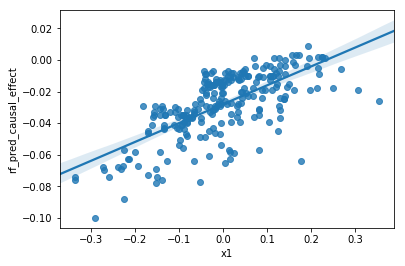

In [18]:
ax = sns.regplot(x = 'x1', y = 'rf_pred_causal_effect', data = ret_df)

In [19]:
test_point = {
    'x1': -0.087134,
    'x2': 0.056415,
    'x3': 0.022938,
    'x4': 0.105300,
    'x5': -0.295644,
    'x6': 1.363628,
    'x7': 0.632985,
    'x8': 0.025216,
    'x9': 0.396586,
    'x10': 1.413206,
    'treatment': 1,
    'design1_y':-0.000815
}

In [20]:
predictDataPoint(rf, test_point)

Predicted causal effect: -0.039

P-value: 0.28
